In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime from datetime
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)  

Populating the interactive namespace from numpy and matplotlib


# BLIF - Bamford Leaky Integrate and Fire 

## Background

These models were created as part of my Masters at reading university. I had a huge interest in neural networks especially with piking neural networks as Deep Learning was not a huge field back then.

I want to try and apply some things I have learned while working with deep learning at import.io, to the models I had while in university. I also have several other ideas that i think I could apply, for example:

* Using sorted sets to store future spike events. 
  * This was previously done using a list of lists which stored the events up to 20 time points in the future. 
  * Can store a limitless number of events in a sorted set, where the item in the set is scored with a timestamp of **expected execution time**. Much like a CPU scheduler
* Implementing Error Backpropagation
  * Can work out how to propagate errors back to previous neurons based on error and time values, this is known as **Spike Time Dependent Plasticity**
  * Can implement some basic output layers such as softmax .
  * Can implement Error functions such as cross entropy, mean squared error etc..
  
  
Generally this is for pure interest and my own personal research. Also its good practice understanding mathematical concepts that come in hanny when doing any kind of ML project.

## BLIF

The BLIF neuron model (renamed from cavalcade because thats a bit shitty) is a spiking neuron model with a very basic activation function.

### Action potential

The neuron's activation potential is reactive to instantaneous spikes (To be more mathematically correct, it is effectively integrating a dirac delta). The neuron then exponentially decays that action potential ($V$) over time with respect to when that spike was recieved. 

$V(t) = \alpha.e^{-(t_{n} - t_{n-1}) \over \epsilon}$

($\epsilon$ here is a "decay factor")


For example: Given a spike $\alpha = 1$ a time $t = 0$ and there are no other spikes

$V(t) = \alpha.e^{-(t - 0) \over \epsilon}$

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8951823150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f894f797410>)

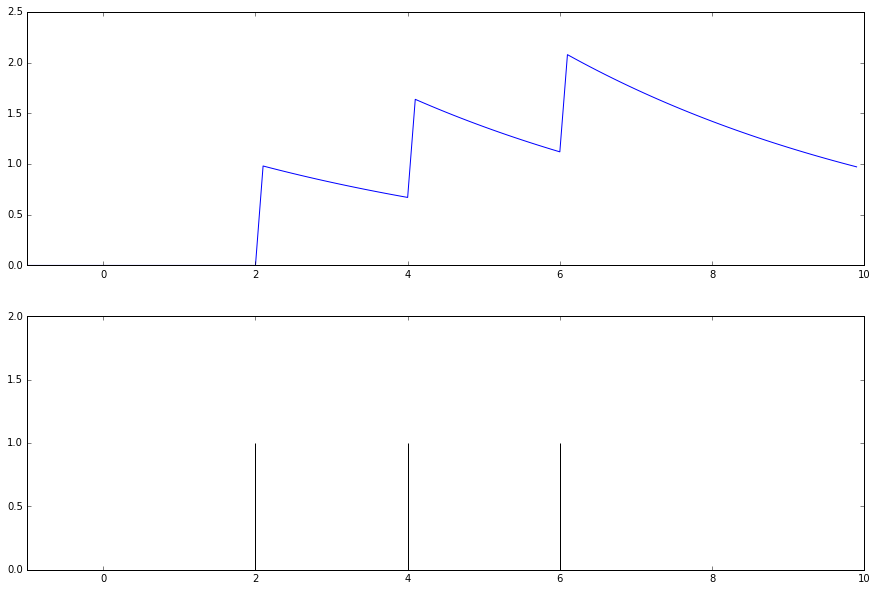

In [7]:
# Definte a function that will plot our action potential
def generate_BLIF(t, phi, A, epsilon):
    
    phi = np.array(phi)
    A = np.array(A)
    
    # Create integratons of diract delta functions for each spike
    D = np.tile(t, (len(phi), 1))
    cidx, ridx = np.where(D.T>=phi)
    D[:,:] = 0
    D[ridx, cidx] = 1
    
    # Decay function for each spike
    E = np.exp(-((t - phi[None,:].T) / epsilon))

    # Multiply integrated spikes with spike strengths
    Da = np.multiply(D.T, A)

    # Sum the product of the exponentials and the integrated dirac step
    Vt = np.sum(Da.T * E, axis=0)
    
    return Vt

# Generate action potential graph using event based method instead of mathematical
def generate_BLIF_events(t, phi, A, epsilon, T=-1):
    
    Vt = np.zeros_like(t)
    prev_Vt = 0
    idx = 0
    prev_fire_t = 0
    
    phi_out = []
    alpha_out = []
    for i, dt in enumerate(t):
        
        Vt_t = prev_Vt*np.exp(-(dt-prev_fire_t)/epsilon) if idx > 0 else 0
        
        if len(phi) > idx and dt > phi[idx]:
            prev_fire_t = dt
            prev_Vt = Vt_t + A[idx]
            idx+=1
        
        if T>0 and Vt_t>T:
            Vt_t = 0
            prev_Vt = 0
            phi_out.append(dt)
            alpha_out.append(1)
        
        
        Vt[i] = Vt_t
        
    return Vt, phi_out, alpha_out
def plot_BLIF(t, phi, A, Vt):

    fig = plt.figure()
    top = fig.add_subplot(211)
    bottom = fig.add_subplot(212)

    top.set_xlim([min, max])
    bottom.set_xlim([min, max])
    bottom.set_ylim([0, 2])

    top.plot(t, Vt.T)
    bottom.vlines(phi, [0], A)
    
    return (top, bottom)


epsilon = 5.0
min = -1.0
max = 10.0

t = np.arange(min, max, 0.1)

# One spike a t=0 with aplitude 1
ts = [2, 4, 6]
alphas = [1.0 , 1.0, 1.0]

Vt = generate_BLIF(t, ts, alphas, epsilon)
plot_BLIF(t, ts, alphas, Vt)

#### Multiple spikes

The action potential with many input spikes can be calculated by adding the spike amplitude to the current action potential and then decaying from that point.

For example: Given a spike $\alpha = 1$ a time $t = 0$ and there is a spike at $t=3$

$V(t)= \cases{
    \alpha.e^{-(t - 0) \over \epsilon} & \text{if } t\lt3\cr
    \alpha.e^{-(3 - 0) \over \epsilon} + \alpha.e^{-(t - 3) \over \epsilon} & \text{if } t\ge3
}$

(<matplotlib.axes.AxesSubplot at 0x7f72bb1ee690>,
 <matplotlib.axes.AxesSubplot at 0x7f72bae37410>)

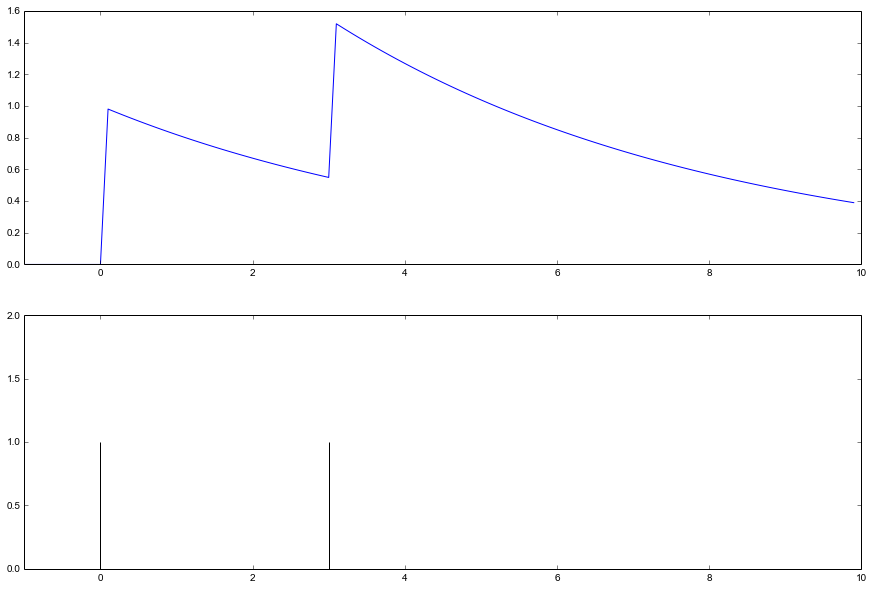

In [42]:
min = -1.0
max = 10.0

t = np.arange(min, max, 0.1)

epsilon = 5
phi = [0, 3]
A = [1, 1]

Vt = generate_BLIF(t, phi, A, epsilon)
plot_BLIF(t, phi, A, Vt)


#### Affect of spike trains on action potential

In the plot_BLIF function above we can use any combination of spike inputs and timing to generate our activation function. If we have a spikes at a frequency of $f = 1/t_{f}$, the action potential will look like this.

(<matplotlib.axes.AxesSubplot at 0x7f6a43439b90>,
 <matplotlib.axes.AxesSubplot at 0x7f6a42dd2790>)

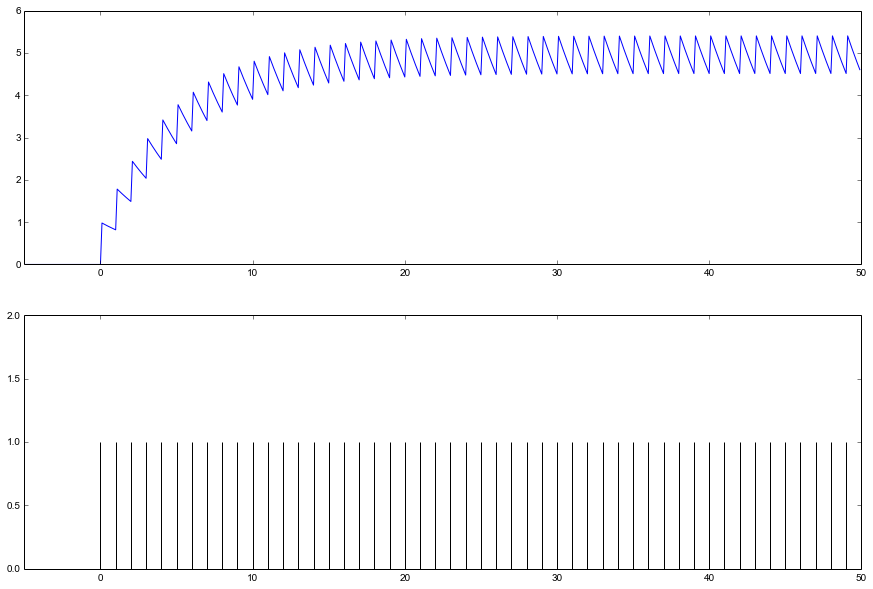

In [138]:
alpha = 1
tf = 1
epsilon = 5

# t = [1,2,3.....n]
min = -5.0
max = 50.0
t = np.arange(min, max, 0.1)

phi = np.arange(0, max, tf)
A = alpha * np.ones_like(phi)

Vt = generate_BLIF(t, phi, A, epsilon)
plot_BLIF(t, phi, A, Vt)

At a fixed frequency, initially the action potential rises very fast, but tends to level off. This will be referred to as the saturation point of the neuron.



### Saturation 

Saturation $\hat U$ is the peak value that the action potential will rise to and stay at over time. 

$\hat U = {\alpha \over {1-e^{-t_{f} \over \epsilon}}}$ with respect to $t_{f}$ (Shown below as a green line)


### Peak curve

The peak curve $U$ is the value that the peaks of the action potential follows. 

$U = {\hat U - \hat U.e^{-t \over \epsilon}}$ (Shown beliw as a red dotted line)



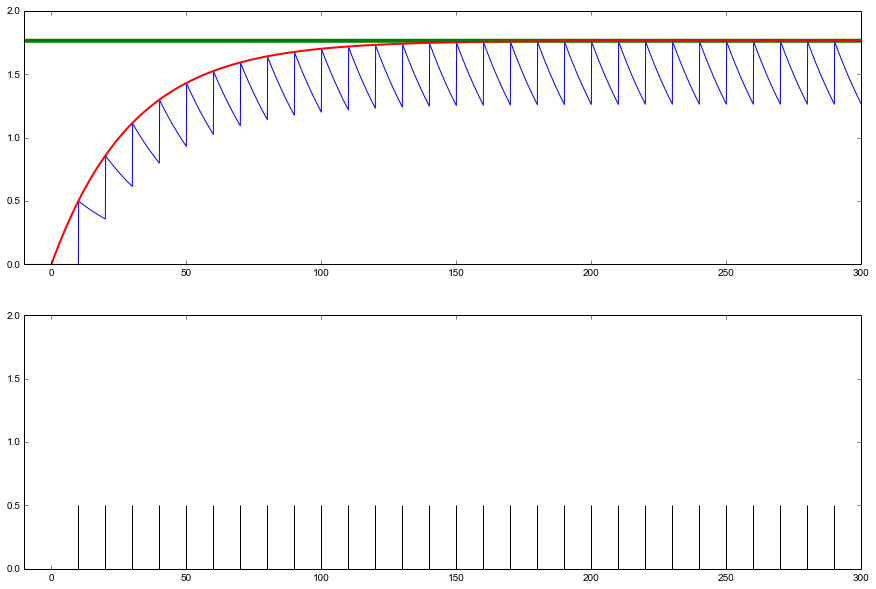

In [140]:
alpha = 0.5
tf = 10.0
epsilon = 30.0

min = -10.0
max = 300.0
t = np.arange(min, max, 0.1)

phi = np.arange(10.0, max, tf)
A = alpha * np.ones_like(phi)
Vt = generate_BLIF(t, phi, A, epsilon)

top, _ = plot_BLIF(t, phi, A, Vt)

# Now we can calculate UHat and U
UHat = alpha/(1-np.exp(-tf/epsilon)) 
UHat_time = UHat * np.ones_like(t)

U_time = UHat - UHat*np.exp(-t/epsilon)

top.set_ylim([0, 2])
top.plot(t, UHat_time, linewidth=4.0, color='g')
top.plot(t, U_time, linewidth=2.0, color='r')


## Threshold firing

The threhold $T$ of a neuron is defined as the value of $V$ where the neuron will fire and reset it's action potential to 0.

As input spikes are discrete events, output spikes are also discrete events that can only occur at the same time as an output spike.

Setting $T$ to 1, the output properties of the neuron act in the following way:

(<matplotlib.axes.AxesSubplot at 0x7f6a435f1fd0>,
 <matplotlib.axes.AxesSubplot at 0x7f6a4349cfd0>)

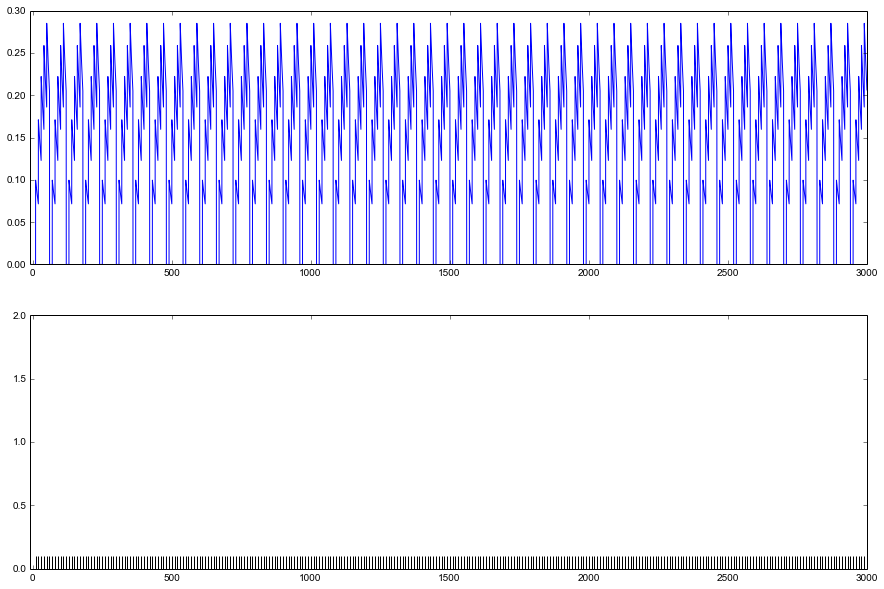

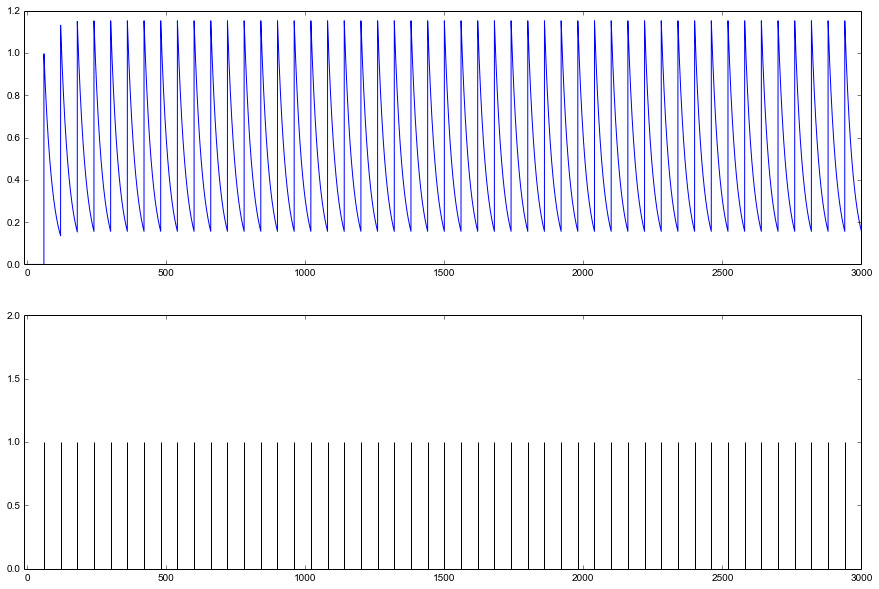

In [100]:
alpha = 0.1
tf = 10.0
epsilon = 30.0

min = -10.0
max = 3000.0
t = np.arange(min, max, 0.1)

phi = np.arange(10.0, max, tf)
A = alpha * np.ones_like(phi)
        
Vt, phi_out, A_out = generate_BLIF_events(t, phi, A, epsilon, 0.2861425008894)
plot_BLIF(t, phi, A, Vt)

Vt_2, _, _ = generate_BLIF_events(t, phi_out, A_out, epsilon, 3)
plot_BLIF(t, phi_out, A_out, Vt_2)

### Using $U$

Sometimes treating the action potential $V$ as the peak curve ignoring the discrete properties of $V$ with respect to spike timing etc, makes some calculations easier. However this is more inaccurate as $t_{f}$ is larger.

Assuming that the action potential is not given by $V$ but more its linear counterpart $U$, the firing time period
for the downstream neuron can be calculated as: 
$t_{f_{out}} = \epsilon \ln {\hat U \over {\hat U - T}}$

for example, if $T=1$ then we have: 

In [12]:
alpha = 0.1
tf = 10.0
epsilon = 30.0
T = 0.2861425008894

UHat = alpha/(1-np.exp(-tf/epsilon)) 

tf2 = epsilon*np.log(UHat/(UHat - T))

print(tf2)

50.0


 Similarly, the threshold $T$ can be calculated based on the input firing frequency and desired output firing frequency
 
 $T = {\hat U ({1 - e^{-t_{f_{out}} \over \epsilon}}})$

In [14]:
alpha = 0.1
tf_in = 10.0
tf_out = 50.0
epsilon = 30.0


UHat = alpha1/(1-np.exp(-tf_in/epsilon1))

T2 = UHat*(1-np.exp(-tf_out/epsilon))

print(T2)

0.286142500889


## Multiple inputs
* maths of having multiple inputs to one neuron at different timings etc. how can we calculate T/UHat/U etc

## Backward dynamics (ignoring spike timing dependence)

Given we have a single neuron and a target output saturation $\hat U_{target}$, can we use stochastic gradient descent in order to adjust $\epsilon$ $\alpha$ or $tf$ and an error function based on the target $\hat U_{target}$?

### Squared Error

Using mean squared error as the error function:

$E = (\hat U_{target} - \hat U)^2$

${dE \over d\hat U} = 2({\hat U - \hat U_{target}})$ 


#### W.R.T $\epsilon$

$\hat U = {\alpha \over {1-e^{-t_{f} \over \epsilon}}}$

${d\hat U \over d\epsilon} = {\hat U}{tf\over{\epsilon^2 (e^{t_{f} \over \epsilon} - 1)}}$

In [150]:
# Initial values
alpha = 0.5
tf = 10.0
epsilon = 30.0

# Target value for U
Utarget = 1.5

# Learing rate
lr = 10

epochs = 100

for i in range(0,epochs):
    
    # Calculate UHat
    UHat = alpha/(1-np.exp(-tf/epsilon)) 
    
    # Calculate error
    E = np.sqrt((Utarget - UHat)**2.0)
    
    if i%10 == 0:
        print("Error: %.2f, UHat: %.2f, epsilon: %.2f" % (E, UHat, epsilon))
    
    # Calculate error derivative
    dE_dUHat = 2*(UHat - Utarget)
    
    # Calculate gradient of neuron W.R.T alpha/tf/epsilon
    dUhat_depsilon = (UHat*tf)/((epsilon**2)*(np.exp(tf/epsilon)-1))
            
    # Calculate delta for alpha/tf/epsilon
    delta = -lr*dE_dUHat*dUhat_depsilon
    
    # Update alpha/tf/epsilon
    epsilon = epsilon + delta

Error: 0.26, UHat: 1.76, epsilon: 30.00
Error: 0.16, UHat: 1.66, epsilon: 27.89
Error: 0.10, UHat: 1.60, epsilon: 26.62
Error: 0.06, UHat: 1.56, epsilon: 25.85
Error: 0.04, UHat: 1.54, epsilon: 25.38
Error: 0.02, UHat: 1.52, epsilon: 25.10
Error: 0.01, UHat: 1.51, epsilon: 24.93
Error: 0.01, UHat: 1.51, epsilon: 24.82
Error: 0.00, UHat: 1.50, epsilon: 24.76
Error: 0.00, UHat: 1.50, epsilon: 24.72


#### W.R.T $tf$

$\hat U = {\alpha \over {1-e^{-t_{f} \over \epsilon}}}$

${d\hat U \over dt_{f}} = {\hat U \over {tf (1 - e^{t_{f} \over \epsilon})}}$

In [84]:
# Initial values
alpha = 0.5
tf = 10.0
epsilon = 30.0

# Target value for U
Utarget = 1.5

# Learing rate
lr = 0.1

epochs = 100

for i in range(0,epochs):
    
    # Calculate UHat
    UHat = alpha/(1-np.exp(-tf/epsilon)) 
    
    # Calculate error
    E = np.sqrt((Utarget - UHat)**2.0)
    
    if i%10 == 0:
        print("Error: %.2f, UHat: %.2f, tf: %.2f" % (E, UHat, tf))
    
    # Calculate error derivative
    dE_dUHat = 2*(UHat - Utarget)
    
    # Calculate gradient of neuron W.R.T alpha/tf/epsilon
    dUhat_dtf = UHat/(tf*(1-np.exp(tf/epsilon)))
    
    # Calculate delta for alpha/tf/epsilon
    delta = -lr*dE_dUHat*dUhat_dtf
    
    # Update alpha/tf/epsilon
    tf = tf + delta
    

Error: 0.26, UHat: 1.76, tf: 10.00
Error: 0.23, UHat: 1.73, tf: 10.22
Error: 0.21, UHat: 1.71, tf: 10.40
Error: 0.19, UHat: 1.69, tf: 10.55
Error: 0.17, UHat: 1.67, tf: 10.68
Error: 0.15, UHat: 1.65, tf: 10.80
Error: 0.14, UHat: 1.64, tf: 10.90
Error: 0.13, UHat: 1.63, tf: 10.99
Error: 0.12, UHat: 1.62, tf: 11.08
Error: 0.11, UHat: 1.61, tf: 11.15


#### W.R.T $a$

$\hat U = {\alpha \over {1-e^{-t_{f} \over \epsilon}}}$

${d\hat U \over d\alpha} = {\hat U \over \alpha}$

In [83]:
# Initial values
alpha = 0.001
tf = 10.0
epsilon = 30.0

# Target value for U
Utarget = 1.5

# Learning rate
lr = 0.01

epochs = 100

for i in range(0,epochs):
    
    # Calculate UHat
    UHat = alpha/(1-np.exp(-tf/epsilon)) 
    
    # Calculate error
    E = np.sqrt((Utarget - UHat)**2.0)
    
    if i%10 == 0:
        print("Error: %.2f, UHat: %.2f, alpha: %.2f" % (E, UHat, alpha))
    
    # Calculate error derivative
    dE_dUHat = 2*(UHat - Utarget)
    
    # Calculate gradient of neuron W.R.T alpha/tf/epsilon
    dUhat_dalpha = UHat/alpha
    
    # Calculate delta for alpha/tf/epsilon
    delta = -lr*dE_dUHat*dUhat_dalpha
    
    # Update alpha/tf/epsilon
    alpha = alpha + delta
    

Error: 1.50, UHat: 0.00, alpha: 0.00
Error: 0.09, UHat: 1.41, alpha: 0.40
Error: 0.00, UHat: 1.50, alpha: 0.42
Error: 0.00, UHat: 1.50, alpha: 0.43
Error: 0.00, UHat: 1.50, alpha: 0.43
Error: 0.00, UHat: 1.50, alpha: 0.43
Error: 0.00, UHat: 1.50, alpha: 0.43
Error: 0.00, UHat: 1.50, alpha: 0.43
Error: 0.00, UHat: 1.50, alpha: 0.43
Error: 0.00, UHat: 1.50, alpha: 0.43


#### W.R.T $T$

The target for this is actually the output frequency rather than the UHat, which in this case is constant.

Therefore we have to calculate the error in terms of $tf_{out}$ and how it propagates a delta to $T$

$t_{f_{out}} = \epsilon \ln {\hat U \over {\hat U - T}}$

${dt_{f_{out}} \over dT} = {\epsilon \over {\hat U - T}}$

N.B when $U_hat$ is smaller than $T$ we have to add a special case where we set $tf_out$ to 0 as it will not fire.

additionally the learning rate is very low otherwise as $T$ gets close to $\hat U$ the gradient becomes infinite

In [5]:
# Initial values
alpha = 0.1
tf = 10.0
epsilon = 30.0
UHat = alpha/(1-np.exp(-tf/epsilon)) 
T = 0.2

delta = 0

# Target value for U
tf_out_target = 50

# Learning rate
lr = 0.000001

epochs = 100

for i in range(0,epochs):
    
    # If Uhat is smaller that T, the neuron will not fure
    if UHat - T >= 0:
        tf_out = epsilon*np.log(UHat/(UHat - T))
    else:
        tf_out = 0
    
    # Calculate error
    E = np.sqrt((tf_out_target - tf_out)**2.0)
    
    if i%10 == 0:
        print("Error: %.2f, T: %.4f, tf_out: %.2f, delta: %.2f" % (E, T, tf_out, delta))
    
    # Calculate error derivative
    dE_dtfout = 2*(tf_out - tf_out_target)

    # If Uhat is smaller than T, we should just reduce T to 0 and let it increase
    if UHat - T >= 0:
        # Calculate gradient of neuron tf W.R.T T
        dtfout_dT = epsilon/(UHat-T)


        # Calculate delta for alpha/tf/epsilon
        delta = -lr*dE_dtfout*dtfout_dT
    else:
        delta = -T
    
    
    # Update T
    T = T + delta

Error: 24.89, T: 0.2000, tf_out: 25.11, delta: 0.00
Error: 3.89, T: 0.2769, tf_out: 46.11, delta: 0.00
Error: 0.03, T: 0.2861, tf_out: 49.97, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00
Error: 0.00, T: 0.2861, tf_out: 50.00, delta: 0.00


### Parameterization
In biological systems, the "strength" of a neuron is not necessarily something that is used to convey information, rather the spike frequency.

Although in the mathematical models above, using alpha as a parameter is the obvious choice due to it's linear relationship with the error, in biological systems this is less realistic and probably more prone to errors in quantization of state information.

When there is more than one neuron in the system, the threshold value might be parameterized.


### NLL
 * just using saturation, how would we change firing frequency or epsilon to get to a target
 * back propagation of simple XOR/classification etc

## Backward dynamics (using spike timing dependence)
 * how do we use the spike timing of multiple neurons to backpropagate deltas at an event level?
 * how do we adjust phase / frequency of incoming spikes.
 * tf must be adjustable (must have linear input that can be turned into a spike train)
 * are the output time dependent functions and we differentiate with respect to time? (can we train to generate a sine wave or something similar) would we need to 
 * can we use recurrent connections to learn output patterns?

In [ ]:
class Neuron:
    def __init__(self, epsilon, T):
        self.prev_fire_time = 0
        self.alpha = 1
        self.epsilon = epsilon
        self.T = T
        pass
    
    def current_UHat(self):
        tf = -self.prev_fire_time
        return alpha/(1-np.exp(-tf/epsilon))
    
    def activate(self, alpha):
    
    
class Axon:
    def __init__(self):
        pass
    
    
    


(<matplotlib.axes._subplots.AxesSubplot at 0x7f894f625a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f894f572390>)

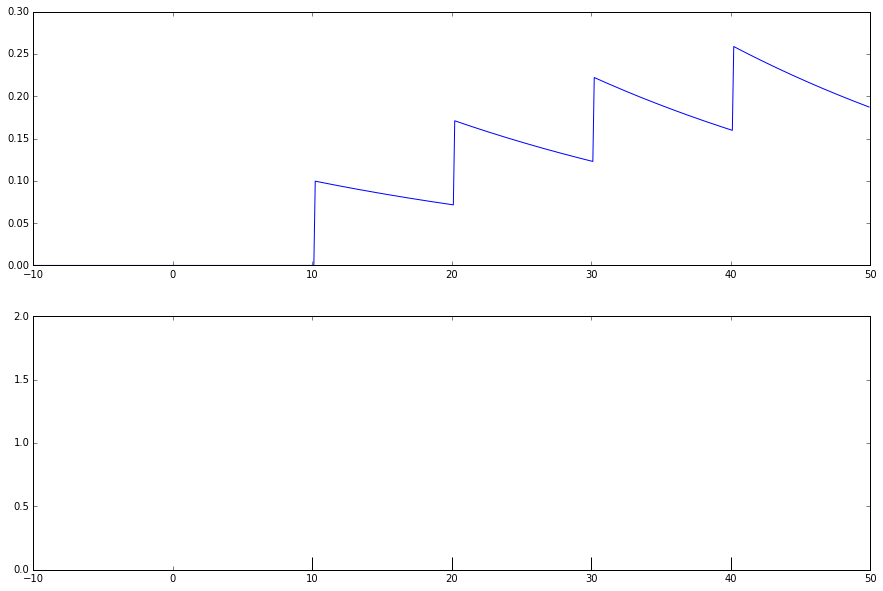

In [9]:
alpha = 0.1
tf = 10.0
epsilon = 30.0

min = -10.0
max = 50.0
t = np.arange(min, max, 0.1)

phi = np.arange(10.0, max, tf)
A = alpha * np.ones_like(phi)
        
Vt, phi_out, A_out = generate_BLIF_events(t, phi, A, epsilon, 0.2861425008894)
plot_BLIF(t, phi, A, Vt)


 
 
# Synaptic delay
 * how do we use synaptic delay to make more interesting patterns?
 * how can we learn the correct synaptic delays to make output patterns?

(<matplotlib.axes.AxesSubplot at 0x7f23e099dd90>,
 <matplotlib.axes.AxesSubplot at 0x7f23e091b710>)

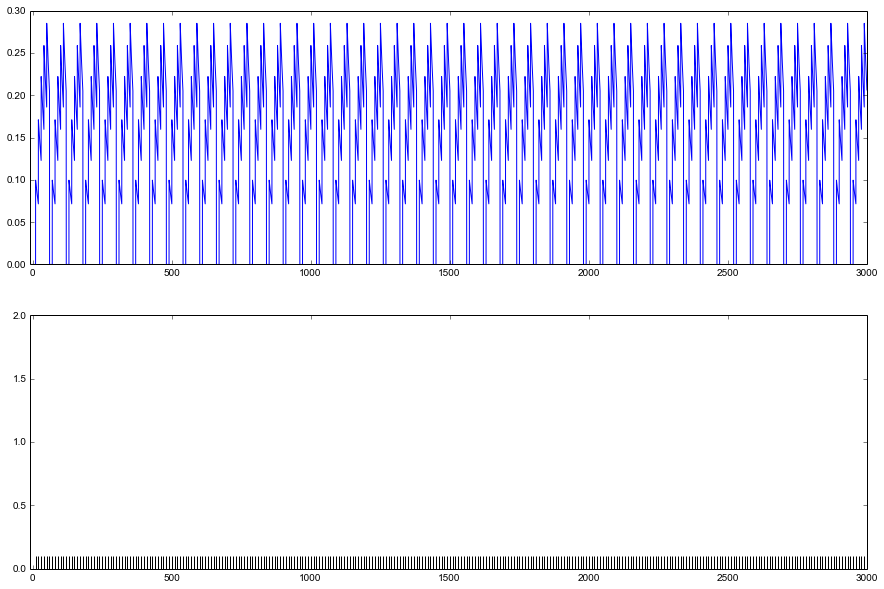

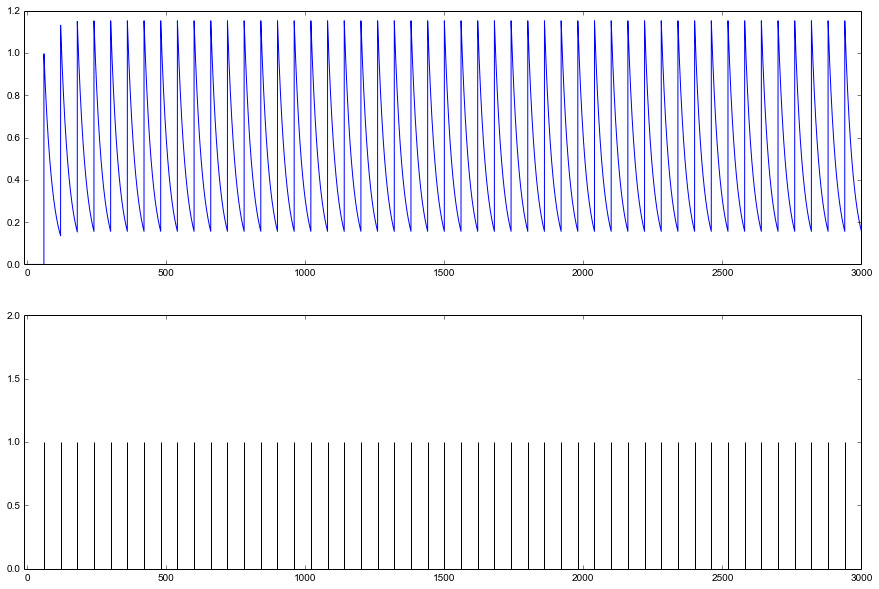

In [153]:
alpha = 0.1
tf = 10.0
epsilon = 30.0

min = -10.0
max = 3000.0
t = np.arange(min, max, 0.1)

phi = np.arange(10.0, max, tf)
A = alpha * np.ones_like(phi)
        
Vt, phi_out, A_out = generate_BLIF_events(t, phi, A, epsilon, 0.2861425008894)
plot_BLIF(t, phi, A, Vt)

Vt_2, _, _ = generate_BLIF_events(t, phi_out, A_out, epsilon, 3)
plot_BLIF(t, phi_out, A_out, Vt_2)

In [130]:


T

0.28614250088935511